In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [12]:
import itertools
from sklearn.model_selection import KFold

In [71]:
import sys
sys.path.append('../..')
from loaders import load_sabes, load_peanut
from utils import apply_df_filters, calc_loadings
#from neurosim.models.var import form_companion

In [4]:
with open('sabes_decoding_df.dat', 'rb') as f:
    decoding_df = pickle.load(f)
with open('sabes_dimreduc_df.dat', 'rb') as f:
    dimreduc_df = pickle.load(f)
with open('sabes_var_df.dat', 'rb') as f:
    var_df = pickle.load(f)
with open('dca_lag_decoding.dat', 'rb') as f:
    dca_lag = pickle.load(f)

### Triplet Loadings/Schur Loadings

In [5]:
# Find correlation between 2-3 unit PI and DCA loadings

In [41]:
import random
from sklearn.decomposition import PCA

In [39]:
from dca.dca import DynamicalComponentsAnalysis as DCA
from dca.cov_util import calc_pi_from_data, calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats

In [10]:
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

In [ ]:
# Triplets

In [89]:
datpath = '/media/akumar/Secondary/data/sabes'
data_files = np.unique(dimreduc_df['data_file'].values)

In [91]:
loadingsDCA = []
loadingsPCA = []

nsamples = 50000
pi_list = []
dca_loadings_list = []

var_list = []
pca_loadings_list = []

for i, data_file in enumerate(data_files):
            
    # DCA
    df_ = apply_df_filters(dimreduc_df, dimreduc='DCA', data_file=data_file, fold_idx=0, dim=2)
    loadings_dca = calc_loadings(df_.iloc[0]['coef'], 1)
    loadingsDCA.extend(loadings_dca)

    df_ = apply_df_filters(dimreduc_df, dimreduc='PCA', data_file=data_file, fold_idx=0)
    loadings_pca = calc_loadings(df_.iloc[0]['coef'][:, 0:2])    
    loadingsPCA.extend(loadings_pca)
    
    dat = load_sabes('%s/%s' % (datpath, data_file), **df_.iloc[0]['loader_args'])

    X = np.arange(np.squeeze(dat['spike_rates']).shape[0])

    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[0]
    
    X = np.squeeze(dat['spike_rates'])[train_idxs]    
    ccm = calc_cross_cov_mats_from_data(X, T=5)
    
    idxs_combos = itertools.combinations(np.arange(X.shape[1]), 3)
    
    idxs = random_combination(idxs_combos, int(min(nsamples, scipy.special.binom(X.shape[1], 3))))
    dcaloadings = np.zeros((len(idxs), 3))
    pcaloadings = np.zeros((len(idxs), 3))
    
    pi = np.zeros(len(idxs))
    var = np.zeros(len(idxs))
    for j in tqdm(range(len(idxs))):
        C = np.zeros((3, X.shape[1]))
        C[0, idxs[j][0]] = 1
        C[1, idxs[j][1]] = 1
        C[2, idxs[j][2]] = 1

        pi_ = calc_pi_from_cross_cov_mats(ccm, proj=C.T)
        pi[j] = pi_
        var[j] = np.trace(C @ ccm[0] @ C.T)
        
        # Also record each of the loadings of the sampled neurons in the DCA projection
        dcaloadings[j, :] = [loadings_dca[idxs[j][0]], loadings_dca[idxs[j][1]], loadings_dca[idxs[j][2]]]
        pcaloadings[j, :] = [loadings_pca[idxs[j][0]], loadings_pca[idxs[j][1]], loadings_pca[idxs[j][2]]]
    pi_list.append(pi)
    var_list.append(var)
    dca_loadings_list.append(dcaloadings)
    pca_loadings_list.append(pcaloadings)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9765.07it/s]


In [92]:
with open('sabes_triplet_loadings.dat', 'wb') as f:
    f.write(pickle.dumps(pi_list))
    f.write(pickle.dumps(dca_loadings_list))
    f.write(pickle.dumps(var_list))
    f.write(pickle.dumps(pca_loadings_list))

In [ ]:
# Do the smae thing for peanut

In [77]:
with open('/home/akumar/nse/grant_notebooks/peanut_dca_dimreduc.dat', 'rb') as f:
    peanut_dimreduc_df = pickle.load(f)

In [95]:
epochs = np.unique(peanut_dimreduc_df['epoch'])

In [96]:
datpath = '/media/akumar/Secondary/data/peanut/data_dict_peanut_day14.obj'

In [97]:
peanut_dimreduc_df.keys()

Index(['data_file', 'loader', 'bin_width', 'epoch', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'T', 'ols_order', 'data_path', 'results_file', 'dim', 'fold_idx',
       'train_idxs', 'test_idxs', 'dimreduc', 'coef', 'score', 'fit_all'],
      dtype='object')

In [98]:
loadingsDCA = []
loadingsPCA = []

nsamples = 50000
pi_list = []
dca_loadings_list = []

var_list = []
pca_loadings_list = []

for i, epoch in enumerate(epochs):
            
    # DCA
    df_ = apply_df_filters(peanut_dimreduc_df, dimreduc='DCA', epoch=epoch, fold_idx=0, dim=2)
    loadings_dca = calc_loadings(df_.iloc[0]['coef'], 1)
    loadingsDCA.extend(loadings_dca)

    df_ = apply_df_filters(peanut_dimreduc_df, dimreduc='PCA', epoch=epoch, fold_idx=0)
    loadings_pca = calc_loadings(df_.iloc[0]['coef'][:, 0:2])    
    loadingsPCA.extend(loadings_pca)
    
    loader_args = {'bin_width':df_.iloc[0]['bin_width'], 'epoch':epoch, 
                   'filter_fn': df_.iloc[0]['filter_fn'], 'filter_kwargs': df_.iloc[0]['filter_kwargs'],
                   'boxcox': df_.iloc[0]['boxcox'], 'spike_threshold': df_.iloc[0]['spike_threshold']}
    
    dat = load_peanut(datpath, **loader_args)

    X = np.arange(np.squeeze(dat['spike_rates']).shape[0])

    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[0]
    
    X = np.squeeze(dat['spike_rates'])[train_idxs]    
    ccm = calc_cross_cov_mats_from_data(X, T=5)
    
    idxs_combos = itertools.combinations(np.arange(X.shape[1]), 3)
    idxs = random_combination(idxs_combos, int(min(nsamples, scipy.special.binom(X.shape[1], 3))))
    dcaloadings = np.zeros((len(idxs), 3))
    pcaloadings = np.zeros((len(idxs), 3))
    
    pi = np.zeros(len(idxs))
    var = np.zeros(len(idxs))
    for j in tqdm(range(len(idxs))):
        C = np.zeros((3, X.shape[1]))
        C[0, idxs[j][0]] = 1
        C[1, idxs[j][1]] = 1
        C[2, idxs[j][2]] = 1

        pi_ = calc_pi_from_cross_cov_mats(ccm, proj=C.T)
        pi[j] = pi_
        var[j] = np.trace(C @ ccm[0] @ C.T)
        
        # Also record each of the loadings of the sampled neurons in the DCA projection
        dcaloadings[j, :] = [loadings_dca[idxs[j][0]], loadings_dca[idxs[j][1]], loadings_dca[idxs[j][2]]]
        pcaloadings[j, :] = [loadings_pca[idxs[j][0]], loadings_pca[idxs[j][1]], loadings_pca[idxs[j][2]]]
    pi_list.append(pi)
    var_list.append(var)
    dca_loadings_list.append(dcaloadings)
    pca_loadings_list.append(pcaloadings)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13244/13244 [00:01<00:00, 10729.04it/s]


In [105]:
scipy.stats.spearmanr(pi_list[6], np.sum(dca_loadings_list[6], axis=1))

SpearmanrResult(correlation=0.6305761997540655, pvalue=0.0)

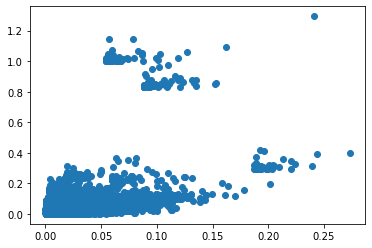

In [27]:
plt.scatter(pi_list[1], np.sum(loadings_list[1], axis=1))

In [29]:
# Overnight - do the 3 neuron calculation

In [33]:
from neurosim.utils.schur_decomposition import schur

In [47]:
# Next question: What is the loading of Schur bases 
loadingsDCA = []
loadingsPCA = []
nsamples = 5000
phi_dca = []
phi_pca = []
for i, data_file in tqdm(enumerate(data_files)):
            
    # DCA
    df_ = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    A = df_.iloc[0]['A']

    dat = load_sabes('%s/%s' % (datpath, data_file), **df_.iloc[0]['loader_args'])
    X = np.arange(np.squeeze(dat['spike_rates']).shape[0])
    train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[0]    
    X = np.squeeze(dat['spike_rates'])[train_idxs]    
    
    dcamodel = DCA(d=1, T=5)
    dcamodel.fit(X)
    pcamodel = PCA(n_components=1)
    pcamodel.fit(X)
    
    # Sort the eigenvalues of A by magnitude
    eigA, _ = np.linalg.eig(A)
    eigorder = np.argsort(np.abs(eigA))[::-1]
    
    T, Z = scipy.linalg.schur(A)
    
    phi_dca_ = np.zeros(T.shape[0])
    phi_pca_ = np.zeros(T.shape[0])
    for j in range(T.shape[0]):
        phi_dca_[j] = scipy.linalg.subspace_angles(Z[:, j][:, np.newaxis], dcamodel.coef_)
        phi_pca_[j] = scipy.linalg.subspace_angles(Z[:, j][:, np.newaxis], pcamodel.components_.T)
    
    phi_dca.append(phi_dca_)
    phi_pca.append(phi_pca_)    
    

28it [03:40,  7.88s/it]


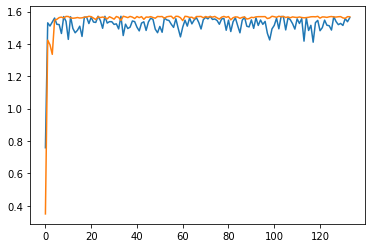

In [54]:
plt.plot(phi_dca[5])
plt.plot(phi_pca[5])

In [55]:
# Top PC is very closely related to the top schur basis vector...

### Plots

In [ ]:
# (1) Lack of corrrelation between PCA/DCA (numerical + data)
# (2) Decoding 
# (3) Single unit correlations

In [132]:
with open('../v3/nn_example.dat', 'rb') as f:
    sim_spearmanr = pickle.load(f)
    sim_phi = pickle.load(f)

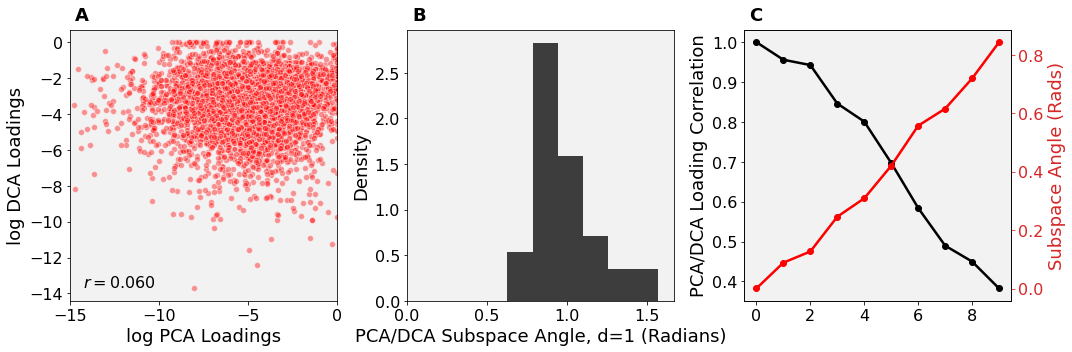

In [192]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

loadingsDCA = []
loadingsPCA = []

subspace_angles = []

# Sabes
for i, data_file in enumerate(data_files):
            
    # DCA
    df_dca = apply_df_filters(dimreduc_df, dimreduc='DCA', data_file=data_file, fold_idx=0, dim=2)
    loadings_dca = calc_loadings(df_dca.iloc[0]['coef'], 1)
    loadingsDCA.extend(loadings_dca)

    df_pca = apply_df_filters(dimreduc_df, dimreduc='PCA', data_file=data_file, fold_idx=0)
    loadings_pca = calc_loadings(df_pca.iloc[0]['coef'][:, 0:2])    
    loadingsPCA.extend(loadings_pca)

    df_dca = apply_df_filters(dimreduc_df, dimreduc='DCA', data_file=data_file, fold_idx=0, dim=1)
    subspace_angles.append(scipy.linalg.subspace_angles(df_dca.iloc[0]['coef'], 
                                                        df_pca.iloc[0]['coef'][:, 0][:, np.newaxis]))
    
for i, epoch in enumerate(epochs):
            
    # DCA
    df_dca = apply_df_filters(peanut_dimreduc_df, dimreduc='DCA', epoch=epoch, fold_idx=0, dim=2)
    loadings_dca = calc_loadings(df_dca.iloc[0]['coef'], 1)
    loadingsDCA.extend(loadings_dca)

    df_pca = apply_df_filters(peanut_dimreduc_df, dimreduc='PCA', epoch=epoch, fold_idx=0)
    loadings_pca = calc_loadings(df_pca.iloc[0]['coef'][:, 0:2])    
    loadingsPCA.extend(loadings_pca)

    subspace_angles.append(scipy.linalg.subspace_angles(df_dca.iloc[0]['coef'], 
                                                        df_pca.iloc[0]['coef'][:, 0][:, np.newaxis]))
    
loadingsDCA = np.array(loadingsDCA)
loadingsPCA = np.array(loadingsPCA)


ax[0].set_facecolor('#f2f2f2')
r = scipy.stats.spearmanr(loadingsDCA, loadingsPCA)[0]
ax[0].set_xlim([-15, 0])

ax[0].scatter(np.log(loadingsPCA), np.log(loadingsDCA), color='r', alpha=0.4, edgecolors='white')
ax[0].text(0.05, 0.05, r'$r = %.3f$' % r, fontsize=16, transform=ax[0].transAxes)

#ax00.set_title('Correlation between Empirical PCA and \n'+\
#                    'Model-Derived State Covariance Loadings', fontsize=24)

ax[0].set_ylabel('log DCA Loadings', fontsize=18)
ax[0].set_xlabel('log PCA Loadings', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)
# ax01.set_title('Correlation between PCA and DCA Loadings', fontsize=24)


### Subspace angles


ax[1].set_facecolor('#f2f2f2')
ax[1].hist(np.array(subspace_angles), range=(0, np.pi/2), bins=10, rwidth=1, color='k', alpha=0.75, density=True)
# r = scipy.stats.spearmanr(loadingsDCA, loadingsPCA)[0]
ax[1].set_xlim([0, np.pi/2 + 0.1])

# ax[1].set_ylabel('log Data Estimated DCA Loadings', fontsize=24)
# ax[1].set_xlabel('log Data Estimated PCA Loadings', fontsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=16)
# ax01.set_title('Correlation between PCA and DCA Loadings', fontsize=24)
ax[1].set_ylabel('Density', fontsize=18)
ax[1].set_xlabel('PCA/DCA Subspace Angle, d=1 (Radians)', fontsize=18)
#### Simulations

ax[2].plot(np.mean(sim_spearmanr, axis=1), '-o', lw=2.5, color='k')
#ax[1, 0].set_ylabel(r'|Re$(\lambda)$|', fontsize=16)
#ax[1, 0].set_xticklabels([])

ax2 = ax[2].twinx()
ax2.plot(np.mean(sim_phi, axis=1),'-o', lw=2.5, color='r')

ax2.set_ylabel('Subspace Angle (Rads)', fontsize=18, color='tab:red')


ax[2].set_facecolor('#f2f2f2')
ax[2].tick_params(axis='both', which='major', labelsize=16)
ax[2].set_ylabel('PCA/DCA Loading Correlation', fontsize=18)
ax2.yaxis.label.set_color('tab:red')
ax2.tick_params(axis='y', which='major', labelsize=16, color='tab:red', colors='tab:red')


# Letters
ax[0].text(0.02, 1.02, 'A', transform=ax[0].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    
ax[1].text(0.02, 1.02, 'B', transform=ax[1].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    
ax[2].text(0.02, 1.02, 'C', transform=ax[2].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    

fig.tight_layout()
#fig.savefig('cosyne_fig1.pdf', bbox_inches='tight', pad_inches=0)
fig.savefig('cosyne_fig1.png', dpi=600, bbox_inches='tight')

In [163]:
with open('/home/akumar/nse/grant_notebooks/peanut_dca_decoding_df.dat', 'rb') as f:
    peanut_decoding_df = pickle.load(f)

In [168]:
################################## Sabes ##########################################
dim_vals = np.arange(1, 50)
fold_idxs = np.unique(decoding_df['fold_idx'].values)
dca_r2 = np.zeros((len(data_files), dim_vals.size, fold_idxs.size, 3))
pca_r2 = np.zeros((len(data_files), dim_vals.size, fold_idxs.size, 3))
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(decoding_df, data_file=data_file, dim=dim, fold_idx=fold_idx)
                
            dca_r2[i, j, k, :] = apply_df_filters(df_, dimreduc='DCA').iloc[0]['r2'][:]
            pca_r2[i, j, k, :] = apply_df_filters(df_, dimreduc='PCA').iloc[0]['r2'][:]

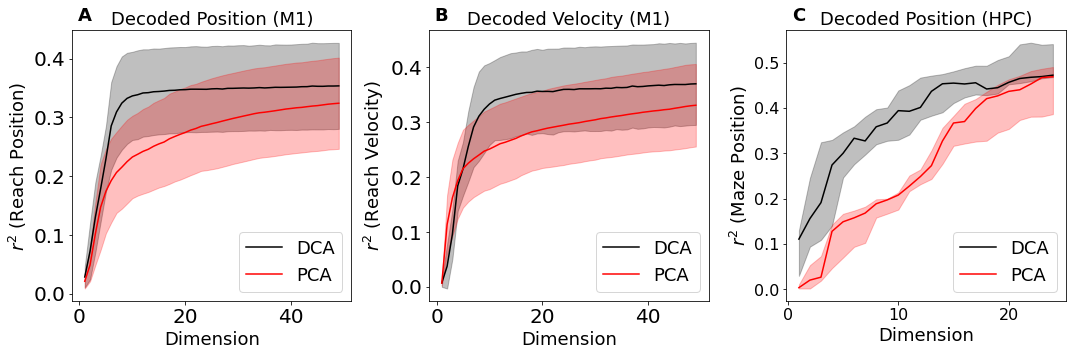

In [193]:
# Seciond plot, Behavioral Decoding
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

################################### Sabes ##########################################                

labels = ['DCA', 'PCA']
        
# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red']
dim_vals = np.arange(1, 50)

for i, r2_ in enumerate([dca_r2, pca_r2]): 
    r2_ = np.nanmean(r2_, axis=2)
    r2_mean = np.nanmean(r2_, axis=0)
    r2_std = np.std(r2_, axis=0)
    ax[0].plot(dim_vals, r2_mean[:, 0], label=labels[i], color=colors[i])
    ax[0].fill_between(dim_vals, r2_mean[:, 0] - r2_std[:, 0], r2_mean[:, 0] + r2_std[:, 0], alpha=0.25, 
                    color=colors[i])
    ax[1].plot(dim_vals, r2_mean[:, 1], label=labels[i], color=colors[i])
    ax[1].fill_between(dim_vals, r2_mean[:, 1] - r2_std[:, 1], r2_mean[:, 1] + r2_std[:, 1], alpha=0.25, 
                    color=colors[i])

ax[0].legend(loc='lower right', fontsize=18)
ax[1].legend(loc='lower right', fontsize=18)
ax[0].set_xlabel('Dimension', fontsize=18)
ax[1].set_xlabel('Dimension', fontsize=18)


ax[0].set_ylabel(r'$r^2$ (Reach Position)', fontsize=18)
ax[1].set_ylabel(r'$r^2$ (Reach Velocity)', fontsize=18)

ax[0].set_title('Decoded Position (M1)', fontsize=18)
ax[1].set_title('Decoded Velocity (M1)', fontsize=18)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)


#################################### Peanut ########################################33

dca_r2p = []
pca_r2p = []

dim_vals = np.arange(1, 25)

for i, epoch in enumerate(epochs):    
    ##### Decoding ######
    dca_df = apply_df_filters(peanut_decoding_df, epoch=epoch, dr_method='DCA', ols_order=3, bin_width=25)
    fold_idxs = np.unique(dca_df['fold_idx'].values)
    dca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(dca_df, dim=dim_val, fold_idx=fold_idx)
            dca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    dca_r2p.append(dca_r2_epoch)
    
    pca_df = apply_df_filters(peanut_decoding_df, epoch=epoch, dr_method='PCA', ols_order=3, bin_width=25)
    pca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(pca_df, dim=dim_val, fold_idx=fold_idx)
            pca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    pca_r2p.append(pca_r2_epoch)
    
dca_r2_median = np.median([np.mean(dca_r2p[i], axis=1) for i in [0, 1, 3, 4, 5, 6, 7]], axis=0)
pca_r2_median = np.median([np.mean(pca_r2p[i], axis=1) for i in [0, 1, 3, 4, 5, 6, 7]], axis=0)

dca_r2_uquantile = np.quantile([np.mean(dca_r2p[i], axis=1) for i in [0, 1, 3, 4, 5, 6, 7]], 0.75, axis=0)
dca_r2_lquantile = np.quantile([np.mean(dca_r2p[i], axis=1) for i in [0, 1, 3, 4, 5, 6, 7]], 0.25, axis=0)

pca_r2_uquantile = np.quantile([np.mean(pca_r2p[i], axis=1) for i in [0, 1, 3, 4, 5, 6, 7]], 0.75, axis=0)
pca_r2_lquantile = np.quantile([np.mean(pca_r2p[i], axis=1) for i in [0, 1, 3, 4, 5, 6, 7]], 0.25, axis=0)


ax[2].plot(np.arange(1, 25), dca_r2_median, 'k')
ax[2].plot(np.arange(1, 25), pca_r2_median, 'r')
ax[2].fill_between(np.arange(1, 25), dca_r2_lquantile, dca_r2_uquantile, alpha=0.25, color='k')
ax[2].fill_between(np.arange(1, 25), pca_r2_lquantile, pca_r2_uquantile, alpha=0.25, color='r')
ax[2].legend(['DCA', 'PCA'], fontsize=18, loc='lower right')
ax[2].set_xlabel('Dimension', fontsize=18)
ax[2].set_ylabel(r'$r^2$' + ' (Maze Position)' , fontsize=18)
ax[2].tick_params(axis='both', labelsize=16)
ax[2].set_title('Decoded Position (HPC)', fontsize=18)
fig.tight_layout()

# Letters
ax[0].text(0.02, 1.02, 'A', transform=ax[0].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    
ax[1].text(0.02, 1.02, 'B', transform=ax[1].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    
ax[2].text(0.02, 1.02, 'C', transform=ax[2].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    

fig.savefig('cosyne/fig2.pdf', bbox_inches='tight', pad_inches=0)

In [181]:
# Consult loadingsVSRsquared notebook
with open('loadings_v_r2_sabes.dat', 'rb') as f:
    _ = pickle.load(f)
    lvr2 = pickle.load(f)

In [182]:
xx = []
yy = []

ww = []
zz = []

for i, data_file in enumerate(data_files):
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    pca_df = apply_df_filters(dimreduc_df, data_file=data_file, fold_idx=0, dimreduc='PCA')
    dca_df = apply_df_filters(dimreduc_df, data_file=data_file, fold_idx=0, dimreduc='DCA', dim=2)
    
    xx.extend(np.diag(df.iloc[0]['W'])/np.max(np.diag(df.iloc[0]['W'])))
    yy.extend(calc_loadings(pca_df.iloc[0]['coef'][:, 0:2], 1))
    
    ww.extend(pi[data_file]['modelT5'])
    zz.extend(calc_loadings(dca_df.iloc[0]['coef'], 1))

xx = np.array(xx)
yy = np.array(yy)
ww = np.array(ww)
zz = np.array(zz)

linmodel = LinearRegression().fit(np.log(yy[:, np.newaxis]), np.log(xx))
r2_supca_pca = linmodel.score(np.log(yy[:, np.newaxis]), np.log(xx))
linmodel = LinearRegression().fit(np.log(zz[:, np.newaxis]), np.log(ww))
r2_sudca_dca = linmodel.score(np.log(zz[:, np.newaxis]), np.log(ww))

linmodel = LinearRegression().fit(np.log(yy[:, np.newaxis]), np.log(ww))
r2_sudca_pca = linmodel.score(np.log(yy[:, np.newaxis]), np.log(ww))
linmodel = LinearRegression().fit(np.log(zz[:, np.newaxis]), np.log(xx))
r2_supca_dca = linmodel.score(np.log(zz[:, np.newaxis]), np.log(zz))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices